<a href="https://colab.research.google.com/github/mrefugionv/S10----PRUEBA-A-B-TIENDA-ONLINE/blob/main/P10_TOMA_DECISIONES_PRUEBA_AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PROYECTO SPRINT 10 : TOMAR DESCISIONES DE NEGOCIO BASADAS EN DATOS

## DESCRIPCIÓN DEL PROYECTO

Eres analista en una gran tienda online. Junto con el departamento de marketing has recopilado una lista de hipótesis que pueden ayudar a aumentar los ingresos.

Tienes que priorizar estas hipótesis, lanzar un test A/B y analizar los resultados.

## PREPARACIÓN DE LOS DATOS

Se importan librerías que se necesitarán.

In [ ]:
import pandas as pd            # Manejo de dataframes
import datetime as dt          # Manejo de fechas
import matplotlib.pyplot as plt  # Graficar
import numpy as np              # Matrices
import seaborn as sns              # Gráfico caja- bigotes
import scipy.stats as stats         # Métodos estadísticos

Se leen las bases de datos.

In [ ]:
# Metricas RICE sobre diversas hipótesis
hypotheses = pd.read_csv('/datasets/hypotheses_us.csv', sep=';')
# Resultados de la prueba A/B, ordenes.
orders = pd.read_csv('/datasets/orders_us.csv')
#Resultados de la prueba A/B, visitas.
visits = pd.read_csv('/datasets/visits_us.csv')

Función para correción de nombres de columnas, que esten en formaton snake_case.

In [ ]:
def col_name_snakecase(data):
    new_col_names =[]

    for old_name in data.columns:
        name_stripped = old_name.strip()
        name_lowered = name_stripped.lower()
        name_no_spaces = name_lowered.replace(' ','_')
        new_col_names.append(name_no_spaces)

    data.columns = new_col_names
    return(data)

hypotheses = col_name_snakecase(hypotheses)

In [ ]:
print(hypotheses.info())
display(hypotheses.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   effort      9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


,hypothesis,reach,impact,confidence,effort
0,Add two new channels for attracting traffic. T...,3,10,8,6
1,Launch your own delivery service. This will sh...,2,5,4,10
2,Add product recommendation blocks to the store...,8,3,7,3
3,Change the category structure. This will incre...,8,3,3,8
4,Change the background color on the main page. ...,3,1,1,1


Se revisa la base de datos "orders":
* Los nombres de las columnas 'transactionId' y 'visitorId' no estaban en snakecase por lo que se les asigna su nombre correctamente.
* Los identificadores ('transactionId', visitorId') estaban en tipo de dato entero. Se pasan a string, ya que no se suelen hacer operaciones matemáticas con ellos.
* La fecha se leyo en tipo de dato string, se asegura que se lea como tipo de dato 'datetime'.

De esta manera obtenemos las base de datos de 1197 filas lista para trabajar, con las siguientes características:
* transaction_id - string - identificador pedido - sin valores faltantes.
* visitor_id - string - identificador de usuario que realizó el pedido - sin valores faltantes.
* date - datetime - fecha de pedido - sin valores faltantes.
* revenue - flotante - ingresos del pedido - sin valores faltantes.
* group - objeto - grupo del test A/B al que pertenece el usuario - sin valores faltantes.


In [ ]:
orders.columns = ['transaction_id','visitor_id','date','revenue','group']
orders['transaction_id'] = orders['transaction_id'].astype('string')
orders['visitor_id'] = orders['visitor_id'].astype('string')
orders['date'] = orders['date'].map( lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
print(orders.info())
display(orders.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   string        
 1   visitor_id      1197 non-null   string        
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   float64       
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1), string(2)
memory usage: 46.9+ KB
None


,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,30.4,B
1,2804400009,3642806036,2019-08-15,15.2,B
2,2961555356,4069496402,2019-08-15,10.2,A
3,3797467345,1196621759,2019-08-15,155.1,B
4,2282983706,2322279887,2019-08-15,40.5,B


Se revisa la base de datos "visits":

* La fecha se leyo en tipo de dato string, se asegura que se lea como tipo de dato 'datetime'.

De esta manera obtenemos las base de datos de 62 filas lista para trabajar, con las siguientes características:
* date - datetime - fecha de visita - sin valores faltantes.
* group - objeto - grupo del test A/B al que pertenece el usuario - sin valores
* visits - entero - número de visitas en la fecha especificada en el grupo de pruebas A/B especificado.

In [ ]:
visits['date'] = visits['date'].map( lambda x: dt.datetime.strptime( x, '%Y-%m-%d'))
print(visits.info())
display(visits.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    62 non-null     datetime64[ns]
 1   group   62 non-null     object        
 2   visits  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
None


,date,group,visits
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


## PARTE 1. PRIORIZAR HIPÓTESIS.

### FRAMEWORK ICE.

Se aplica el framework ICE para priorizar hipótesis y se ordenarlas en orden descendente de prioridad.

Recordemos que entre mayor sea el valore ICE indica que es más viable realizar esa prueba de hipótesis. Ya que el valor ICE se obtinen de la siguiente manera:

                 ICE = (Impacto * Confinza) / Esfuerzo

Se pretende que los dos numeradores sea altos en su escala y que el denominador sea pequeño en su escala.

In [ ]:
hypotheses['ICE'] = (hypotheses['impact']*hypotheses['confidence'])/hypotheses['effort']
ice_results = hypotheses[['hypothesis','ICE']].sort_values(by='ICE',ascending= False)

### FRAMEWORK RICE

Se aplica el framework RICE para priorizar hipótesis y se ordena en orden descendente de prioridad.

Recordemos que entre mayor sea el valore ICE indica que es más viable realizar esa prueba de hipótesis. Ya que el valor RICE se obtiene de manera similar a ICE pero se agrega el alcance (reach):

                 ICE = (Reach * Impact * Confidence) / Effort

Se pretende que los tres numeradores sea altos en su escala y que el denominador sea pequeño en su escala.

In [ ]:
hypotheses['RICE'] = (hypotheses['reach'] * hypotheses['impact']*hypotheses['confidence'])/hypotheses['effort']
rice_results = hypotheses[['hypothesis','RICE']].sort_values(by='RICE',ascending= False)


### ICE VS RICE

Se observa un cambio de priorización cuando se utiliza el fremwork Rice a cuando se utiliza el framework ICE. Esto se debe a que con el framwork RICE se añade una variable más, la valoración del alcance (reach). Esta variable es independiente a cada una de las demás variables en cada una de las valoraciones de las hipótesis, por lo que una hipotesis que tenía un valor más pequeno en de impacto y confiaza puede tener un alto valor de alcance y viceversa.

Con este ejemplo podemos observar que la hipótesis 7 que teníamos en tercer lugar con ICE, considerando el alcance, se vuelve nuestra priorida. Le puede llegar a más usuarios un formato de suscripción a traves de las páginas principales que, como se formula en la hipotesis 8 (prioridad con ICE), lanzar una promoción de descuentos; probablemente los descuentos por cada usuario a que se llegue tenga un mayor costo que el formato de suscripción.

In [ ]:
print(ice_results)
print(rice_results)

                                          hypothesis        ICE
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000
                                          hypothesis   RICE
7  Add a subscription form to all the main pages....  112.0
2  Add product recommendation blocks to the store...   56.0
0  Add two new channels for attracting traffic. T...   40.0
6  Show banners with current offers and sales on ...   40.0
8  Launch a promotion that gives users discounts ...   16.2


## PARTE 2. ANÁLISIS DE TEST A/B

### PROCESAMIENTO DE DATOS. Cada visitante solo en un grupo A/B.

Asegúrate de preprocesar los datos. Es posible que haya errores en los datasets originales; por ejemplo, algunos de los visitantes podrían haber entrado tanto en el grupo A como en el grupo B.

Para revisar si hay algun visitante que se encuentre tanto en grupo A como en grupo B, se realizó el siguiente procedimiento:
1. Se crea la lista de los visitantes en el grupo A y la lista de los visitantes del grupo B, mediante un filtrado de dataset 'orders'.
2. Mediante el método 'merge inner' sobre las columnas del identificador del visitante de los respectivos grupos, se obtienen aquellos visitantes que se encuentran en ambos grupos.
3. Mediante un filtrado del del data frame orderr origingal, mantenemos aquellos visitantes que no se encuentran en la lista de identificadores del dataframe obtenido en el paso 2.

En es este caso obtuvimos un dataframe de 183 visitantes repetidos en grupo A y B. Por lo que 'orders' queda con 1016 registros

In [ ]:
visitorsA = orders[orders['group']=='A']
visitorsB = orders[orders['group']=='B']
#print(visitorsA.info()) # 557 registros
#print(visitorsB.info()) # 640 registros

#Inner merge con las columnas de visitor_id, de los grupos visitorsA y visitorsB
visitors_both_groups =  visitorsA.merge(visitorsB, how='inner', on='visitor_id',suffixes=('_a', '_b'))
print(visitors_both_groups.info())
#display(visitors_both_groups.head())

#Filtramos dataframes originales (orders y visitors)
orders = orders[~orders['visitor_id'].isin(visitors_both_groups['visitor_id'])]
print(orders.info())
#display(orders.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 183 entries, 0 to 182
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id_a  183 non-null    string        
 1   visitor_id        183 non-null    string        
 2   date_a            183 non-null    datetime64[ns]
 3   revenue_a         183 non-null    float64       
 4   group_a           183 non-null    object        
 5   transaction_id_b  183 non-null    string        
 6   date_b            183 non-null    datetime64[ns]
 7   revenue_b         183 non-null    float64       
 8   group_b           183 non-null    object        
dtypes: datetime64[ns](2), float64(2), object(2), string(3)
memory usage: 14.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0  

### MÉTRICAS ACUMULADAS

Para evitar el "peeking problem", los analistas examinan gráficos de métricas acumuladas.

El "problema de mirar" (peeking problem) se refiere a la práctica de analizar los resultados de una prueba antes de que se haya completado la duración predeterminada o haya alcanzado un nivel de significancia estadística. Esto puede llevar a conclusiones prematuras y sesgadas.

La métricas acumuladas se refieren a que en el punto del primer día tendrás los valores de las métricas para ese día, en el punto del segundo día tendrás la suma de las métricas de los dos primeros días y así en adelante

Se crea un dataframe con los datos acumulados:
* date : fecha
* group:  A o B
* orders : cantidad de pedidos únicos hasta esa fecha por ese grupo
* buyers : cantidad de visitantes únicos hasta esa fecha por ese grupo
* revenue: suma de tamaño promedio de compra para ese grupo y hasta fecha
* visitors : suma de visitantes totales hasta esa fecha por ese grupo


In [ ]:


#  Matriz de valores únicos por pareja fecha-grupo
datesGroups = orders[['date','group']].drop_duplicates()

# Filtro: fecha es menor o igual que la fecha del elemento datesGroups
# Como haber calculado los resultados de nuestra prueba todos los días hasta la fecha actual
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : pd.Series.nunique, 'visitor_id' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# Mismo con df visits
visitorsAggregated = datesGroups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visits' : 'sum'}), axis=1).sort_values(by=['date','group'])

# Fusiona las dos tablas en una y da a sus columnas nombres descriptivos
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulativeData.head())

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,2266.6,719
1,2019-08-01,B,17,17,967.2,713
2,2019-08-02,A,42,36,3734.9,1338
3,2019-08-02,B,40,39,3535.3,1294
4,2019-08-03,A,66,60,5550.1,1845


#### 1. INGRESO ACUMULADO POR GRUPO

Podemos observar que la ganacia en ingresos acumulados para el grupo B con respecto al grupo A, va en aumento. Esto indica que la prueba sí generó un cambio significativo en las compras de los usuarios.

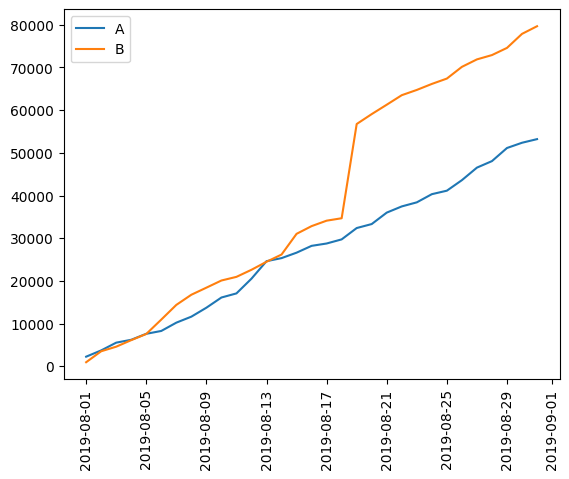

In [ ]:
# DataFrame con pedidos acumulados e ingresos acumulados por día, grupo A y grupo B
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
# Trazar el gráfico de ingresos del grupo A y grupo B
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.xticks(rotation=90)
plt.legend()

#### 2. TAMAÑO DE PEDIDO PROMEDIO ACUMULADO

El tamaño promedio de pedido acumulado  esta dado por:

    tamaño_promedio_acumulado = ingresos_acumulados / cantidad_de_pedidos_acumulados


En este caso, se observa inestable al inicio; sin embargo desde el inicio, y conforme se va estabilizando,  se observa una ganacia significativa del grupo B con respecto al grupo A. Para determinar si parar o seguir con la prueba, hay que tomar en cuenta que después del pico máximo de tamaño promedio de pedido en el grupo B tiene una inclinación negativa.


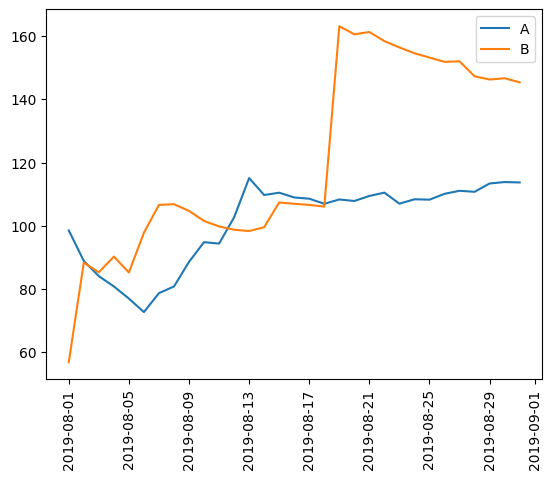

In [ ]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=90)
plt.legend()

#### 3.  DIFERENCIA RELATIVA EN EL TAMAÑO DE PEDIDO PROMEDIO ACUMULADO

Diferencia relativa = (metrica_acumulada_grupo_B / metrica_acumulada_grupo_A)  -1)

Para estos gráficos los puntos que son mayores a 0 representa una ganacia en el grupo B sobre la métrica, mientras que los valores menores a 0 una pérdida.

En este caso vemos que el cambio que se realizo en la prueba a generado cambio significativos positivos, llegando a tener tamaño promedio de venta de hasta 0.5 mayor. Sin embargo se recomendaría continuar con la prueba, hasta obervar la estabilización, ya que la tendencia va en decaimiento.

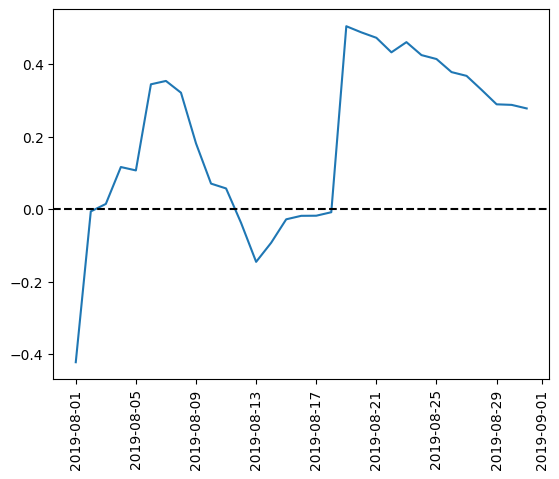

In [ ]:
#Reunir los datos acumulados de grupo A y  grupo B en un solo DataFrame
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# Graficar diferencia relativa para los tamaños de compra promedio
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
plt.xticks(rotation=90)
# Agrega el eje X en 0
plt.axhline(y=0, color='black', linestyle='--')

#### 4. TASA DE CONVERSIÓN DE CADA GRUPO

La tasa de conversión  = # de pedidos diarios / # de visitas diarias

Esta métrica nos muestra la relación entre la cantidad de visitas que tenemos y el número de vistas, esntre mayor sea  indica que hay mas cantidad de compras por visitas. Observamos que en este caso el grupo B presenta continuamente mayor tasa de conversión.

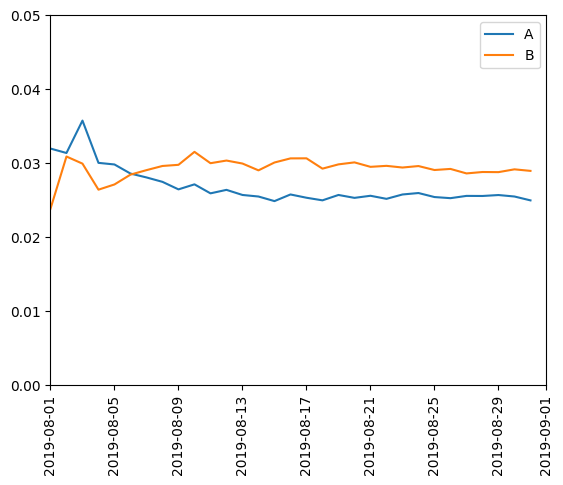

In [ ]:
# Cálculo de conversión acumulada
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
# Datos en el grupo A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# Datos en el grupo B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
# Trazar los gráficos
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.axis([pd.to_datetime("2019-08-01"), pd.to_datetime('2019-09-01'), 0, 0.05]) # Configuración del eje x
plt.xticks(rotation=90)
plt.legend()


### VALORES ATÍPICOS

#### 5.NÚMERO DE PEDIDOS POR USUARIO

En este gráfico de dsipersión el eje 'y' representa la cantidad de pedidos del usurio y el eje x es la cantidad de usuarios. Por lo que podemos ver solo alrededor de 25 usuarios de los, aproximadamente, 1000 de los que se tiene registro, han realizado más de 1 pedido, siendo en su mayoría de estos 2 compras; los usuario que más compras han realizado, ha hecho 3 pedidos.

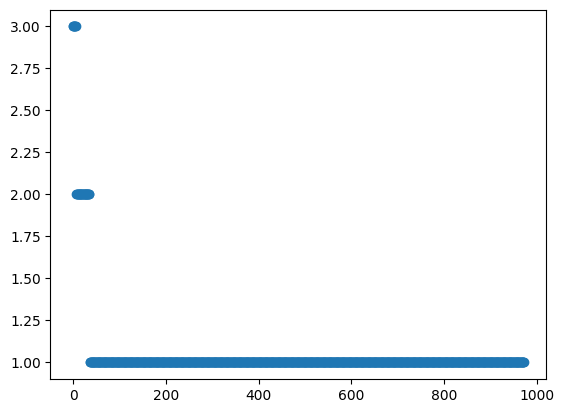

In [ ]:
# Encontrar el número de pedidos por usuario

ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsers.columns =['userId','orders']
ordersByUsers= ordersByUsers.sort_values(by='orders',ascending=False)
#print(ordersByUsers.head(10))

x_values = pd.Series(range(0,len(ordersByUsers)))
plt.scatter(x_values,ordersByUsers['orders'])

#### 6. PERCENTILES PEDIDOS POR USUARIO

Los percentiles dividen un conjunto ordenado en 100 partes, el percentil número n marca el valor mayor que n por ciento de los valores en la muestra.

Por ejemplo, en este caso tenemos un percentil 95 de 2. Lo que quiere decir que solo el 5% de los 1197 usuarios han realizado más de dos compras. También obtuvimos un percentil 99 de 4, es decir que solo el 1% de los usuarios han realizado más de 4 compras.

In [ ]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


#### 7. DISPERSIÓN DE LOS PRECIOS DE LOS PEDIDOS

De acuerdo al gráfico de dispersión observamos que la mayor parte de los pedidos tienen una valor menor a 2500 (unidad de moneda), solo 2 de los pedidos tienen un valor mayor ( 20,000 y 3000 aproximadamente).

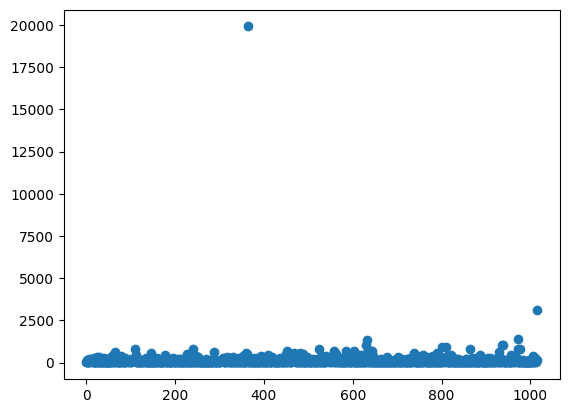

In [ ]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values,orders['revenue'])

#### 8. PERCENTILES DE LOS PRECIOS

Obtenemos que solo el 5% de los pedidos tiene un valor mayor a 414.275 y solo el 1% de los pedidos tiene unvalor mayor a 830.3

In [ ]:
print(np.percentile(orders['revenue'], [95, 99]))

[414.275 830.3  ]


### SIGNIFICACIA ESTADÍSTICA

#### DATOS EN BRUTO (CON VALORES ATÍPICOS)

In [ ]:
#CREACIÓN DE MUESTRAS

#Crearemos las variables ordersByUsersA y ordersByUsersB para almacenar cant de compras por usuario de cada grupo ['visitor_id', 'orders'].
ordersByUsersA = orders[orders['group']=='A'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersA.columns = ['visitor_id', 'orders']
ordersByUsersB = orders[orders['group']=='B'].groupby('visitor_id', as_index=False).agg({'transaction_id' : pd.Series.nunique})
ordersByUsersB.columns = ['visitor_id', 'orders']

#Preparar las muestras para la prueba de Mann-Whitney:  sampleA y sampleB.
# sample (de largo de visits)= concatena #odenes por usuario y los 0 usuarios que no pidieron nada.
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


##### 9. S.E. DE LA DIFERENCIA EN LA CONVERSIÓN DE LOS GRUPOS

Aplicando el método de Mann-Whitney,un método de prueba de hipótesis entre dos poblaciones con valores atípicos, se obtuvo una siginificancia menor a 0.05 (valor de alpha) lo que nos indica que si hay diferencia significativa de conversión para los grupos A y B; con una ganacia de 0.138 de ganacia para el grupo B.

In [ ]:

# Método de mannwhitney
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1])) #valor p

#Ganancia relativa de conversión para el grupo B.
#Tasa de conversión = suma de pedidos / cantidad de usuarios = mean(sample)
print("{0:.3f}".format(sampleB.mean()/sampleA.mean()-1))


0.011
0.160


##### 10. S.F. DE LA DIFERENCIA EN EL TAMAÑO PROMEDIO DE PEDIDO

Se obtuvo una siginificancia mayor a 0.05 (valor de alpha) lo que nos indica que no se puede rechazar la hipotesis nula ( No hay cambios entre los grupos); sin embargo observamos una  ganacia relativa de 0.252 para el grupo B con respecto al tamaño promedio de pedido del grupo A.

In [ ]:

#Método de mannwhitney
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
#Ganancia relativa de conversión para el grupo B
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.862
0.278


#### DATOS FILTRADOS (SIN VALORES ATÍPICOS)

In [ ]:
#CREACIÓN DE MUESTRAS FILTRADAS

# Encontrar los usuarios anómalos con el método shape() -  percentiles 95 de ingreso y de cantidad de orders
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitor_id'], ordersByUsersB[ordersByUsersB['orders'] > 2]['visitor_id']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 435.54]['visitor_id']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
display(abnormalUsers.head(5))
print(abnormalUsers.shape)

#Prepararemos muestras del número de pedidos por usuario para cada grupo de prueba:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])),name='orders')],axis=0)
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))]['orders'],pd.Series(0, index=np.arange(visits[visits['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])),name='orders')],axis=0)


1103    1164614297
137     1211585711
1136    1307669133
421     1357170471
549     1367935136
Name: visitor_id, dtype: object

(55,)


##### 11. S.E. DE LA DIFERENCIA EN LA CONVERSIÓN DE LOS GRUPOS

Obtenemos una difnificacia estadística menor a alpha (0.05) y una ganancia relativa de 0.173 para el grupo B en cuanto a la conversión de los usuarios.

In [ ]:
# Método de Mann Whitney
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
# Ganancia relativa grupo B
print("{0:.3f}".format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.009
0.189


##### 12. S.F. DE LA DIFERENCIA EN EL TAMAÑO PROMEDIO DE PEDIDO

Se obtiene una significaia estadística de 0.788, mayor a alfa(0.05), por lo que no se rechaza la hipótesis nula (El tamaño promedio de pedido se mantiene entre los grupos). Y una ganacia relativa negativa, es decir que en general el tamaño promedio de pedido es mayor en el grupo A.

In [ ]:

# Prueba U de Mann-Whitney
print("{0:.3f}".format(stats.mannwhitneyu(
    orders[np.logical_and( orders['group']=='A',  # Selecciona datos en el grupo A
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)) # Excluye los usuarios anormales
                         )]['revenue'],   # Tamano de compra para los usuarios grupo A que no son anomales
    orders[np.logical_and(
        orders['group']=='B',  # Selecciona datos en el grupo B
        np.logical_not(orders['visitor_id'].isin(abnormalUsers)) # Excluye los usuarios anormales
    )]['revenue']  # Tamano de compra para los usuarios grupo B que no son anomales
)[1])) # Selecciona el valor p del resultado.

# Diferencia relativa en el ingreso medio entre los grupos B y A
print("{0:.3f}".format(
    orders[np.logical_and(orders['group']=='B',
           np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() /  # Calcula el ingreso medio para el grupo B sin usuarios anormales
    orders[np.logical_and(orders['group']=='A',
           np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue'].mean() - 1)) # Calcula el ingreso medio para el grupo B sin usuarios anormales

0.798
-0.022


### 13. TOMA DE DESICIÓN

 Las decisiones posibles basada en los resultados de la prueba son:
 1. Parar la prueba, considerar a uno de los grupos como líder.
 2. Parar la prueba, concluir que no hay diferencia entre los grupos.
 3. Continuar la prueba.

Tomando en cuenta todas las observaciones en el reporte, se toma la decisión:

1. Parar la prueba, se considera el grupo B como líder.
   
A lo largo de los análisis se observa que aunque no hay grandes diferencia en el tamaño promedio de compra entre los grupos, sí hay una clara diferencia en la tasa de conversión siendo mayor la del grupo B; lo cual también incrementa las ganancias que tienen la empresa.

Podemos revisar estos resultados redirigiendo nuestra atención tanto en el punto 1) Gráfica de ingreso acumulado por grupo, 4) Gráfica de tasa de conversión acumulada por grupo, 9) y 11) Pruebas de Mann Withney para la tasas de conversión tanto con los datos filtrados como brutos.